# Catboost Classifier

## Importing the necessary libraries

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from sklearn import metrics
from catboost import CatBoostClassifier
from sklearn.model_selection import RandomizedSearchCV
import joblib

## Loading the Processed Dataset

In [2]:
data = pd.read_csv("preprocessed.csv")

In [3]:
data.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,Date_month,Date_day
0,2008-12-01,30,13.4,22.9,0.6,2.4,8.3,4.0,44.0,5.0,...,1007.7,1007.1,8.0,7.0,16.9,21.8,0,0,12,1
1,2008-12-02,30,7.4,25.1,0.0,3.6,10.0,2.0,44.0,0.0,...,1010.6,1007.8,7.0,7.0,17.2,24.3,0,0,12,2
2,2008-12-03,30,12.9,25.7,0.0,2.6,4.4,5.0,46.0,5.0,...,1007.6,1008.7,7.0,2.0,21.0,23.2,0,0,12,3
3,2008-12-04,30,9.2,28.0,0.0,14.6,8.9,11.0,24.0,13.0,...,1017.6,1012.8,7.0,7.0,18.1,26.5,0,0,12,4
4,2008-12-05,30,17.5,32.3,1.0,5.4,3.0,4.0,41.0,12.0,...,1010.8,1006.0,7.0,8.0,17.8,29.7,0,0,12,5


In [4]:
data.shape

(145460, 25)

In [5]:
df = data.sample(n = 12000)

In [6]:
df.shape

(12000, 25)

## Dividing the dataset into Independent and Dependent features

In [7]:
X = df.drop(["RainTomorrow", "Date"], axis=1)
y = df["RainTomorrow"]

### Train test split

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size =0.2, stratify = y, random_state = 0)

In [9]:
y_train

49541     0
106044    0
6091      0
66107     1
129724    0
         ..
109529    1
8930      0
123034    0
3237      0
37748     0
Name: RainTomorrow, Length: 9600, dtype: int64

## Handling imbalanced dataset

C:\Users\SWARNAVA\anaconda3\envs\rain\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='RainTomorrow', ylabel='count'>

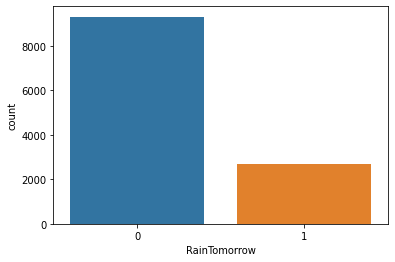

In [10]:
sns.countplot(df["RainTomorrow"])

In [11]:
sm=SMOTE(random_state=0)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)
print("The number of classes before fit {}".format(Counter(y_train)))
print("The number of classes after fit {}".format(Counter(y_train_res)))

The number of classes before fit Counter({0: 7457, 1: 2143})
The number of classes after fit Counter({0: 7457, 1: 7457})


### Catboost Classifier

In [13]:
cat = CatBoostClassifier(iterations=25, eval_metric = "AUC")
cat.fit(X_train_res, y_train_res)

Learning rate set to 0.5
0:	total: 86.6ms	remaining: 2.08s
1:	total: 140ms	remaining: 1.61s
2:	total: 182ms	remaining: 1.33s
3:	total: 237ms	remaining: 1.25s
4:	total: 281ms	remaining: 1.12s
5:	total: 324ms	remaining: 1.03s
6:	total: 367ms	remaining: 945ms
7:	total: 419ms	remaining: 890ms
8:	total: 467ms	remaining: 830ms
9:	total: 510ms	remaining: 765ms
10:	total: 556ms	remaining: 708ms
11:	total: 627ms	remaining: 679ms
12:	total: 679ms	remaining: 627ms
13:	total: 724ms	remaining: 569ms
14:	total: 769ms	remaining: 512ms
15:	total: 822ms	remaining: 462ms
16:	total: 876ms	remaining: 412ms
17:	total: 938ms	remaining: 365ms
18:	total: 997ms	remaining: 315ms
19:	total: 1.06s	remaining: 265ms
20:	total: 1.11s	remaining: 211ms
21:	total: 1.16s	remaining: 158ms
22:	total: 1.21s	remaining: 106ms
23:	total: 1.28s	remaining: 53.2ms
24:	total: 1.33s	remaining: 0us


In [14]:
y_pred = cat.predict(X_test)
print(confusion_matrix(y_test,y_pred))
print(accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[1684  180]
 [ 215  321]]
0.8354166666666667
              precision    recall  f1-score   support

           0       0.89      0.90      0.90      1864
           1       0.64      0.60      0.62       536

    accuracy                           0.84      2400
   macro avg       0.76      0.75      0.76      2400
weighted avg       0.83      0.84      0.83      2400



0.7511570367048876

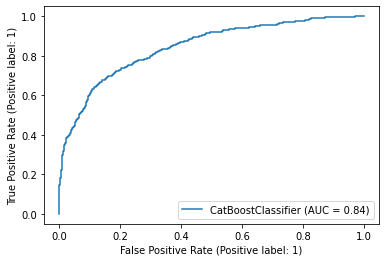

In [15]:
metrics.plot_roc_curve(cat, X_test, y_test)
metrics.roc_auc_score(y_test, y_pred, average=None)

## Hyperparameter Optimization

In [16]:
#Randomized Search CV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1200, num = 12)]
# Various learning rate parameters
learning_rate = [0.05,0.1, 0.2,0.3,0.5,0.6]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 30, num = 6)]
# max_depth.append(None)
#Subssample parameter values
subsample=[0.7,0.6,0.8]
# Minimum child samples parameters
min_child_samples=[3,4,5,6,7]

In [17]:
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'learning_rate': learning_rate,
               'max_depth': max_depth,
               'subsample': subsample,
               'min_child_samples': min_child_samples}

print(random_grid)

{'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200], 'learning_rate': [0.05, 0.1, 0.2, 0.3, 0.5, 0.6], 'max_depth': [5, 10, 15, 20, 25, 30], 'subsample': [0.7, 0.6, 0.8], 'min_child_samples': [3, 4, 5, 6, 7]}


In [21]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
cat = CatBoostClassifier()

In [22]:
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations
cat_random = RandomizedSearchCV(estimator = cat, param_distributions = random_grid, n_iter = 5, cv = 3, verbose=2, random_state=100, n_jobs = -1)

In [23]:
cat_random.fit(X_train_res, y_train_res)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


C:\Users\SWARNAVA\anaconda3\envs\rain\lib\site-packages\sklearn\model_selection\_search.py:925: UserWarning: One or more of the test scores are non-finite: [0.83707743        nan        nan 0.82849547        nan]
  category=UserWarning


0:	learn: 0.4772891	total: 709ms	remaining: 10m 37s
1:	learn: 0.3956871	total: 1.24s	remaining: 9m 14s
2:	learn: 0.3556093	total: 1.71s	remaining: 8m 31s
3:	learn: 0.3313412	total: 2.21s	remaining: 8m 14s
4:	learn: 0.3104662	total: 2.77s	remaining: 8m 16s
5:	learn: 0.2899015	total: 3.27s	remaining: 8m 6s
6:	learn: 0.2752223	total: 3.83s	remaining: 8m 8s
7:	learn: 0.2618710	total: 4.24s	remaining: 7m 52s
8:	learn: 0.2496156	total: 4.66s	remaining: 7m 41s
9:	learn: 0.2394297	total: 5.1s	remaining: 7m 33s
10:	learn: 0.2239978	total: 5.47s	remaining: 7m 22s
11:	learn: 0.2147894	total: 5.9s	remaining: 7m 16s
12:	learn: 0.2037932	total: 6.33s	remaining: 7m 12s
13:	learn: 0.1954785	total: 6.8s	remaining: 7m 10s
14:	learn: 0.1872842	total: 7.23s	remaining: 7m 6s
15:	learn: 0.1811843	total: 7.6s	remaining: 6m 59s
16:	learn: 0.1748030	total: 8.16s	remaining: 7m 4s
17:	learn: 0.1644603	total: 8.62s	remaining: 7m 2s
18:	learn: 0.1572381	total: 9.01s	remaining: 6m 57s
19:	learn: 0.1498981	total: 9.

159:	learn: 0.0048825	total: 1m 1s	remaining: 4m 45s
160:	learn: 0.0048274	total: 1m 2s	remaining: 4m 45s
161:	learn: 0.0047685	total: 1m 2s	remaining: 4m 44s
162:	learn: 0.0047218	total: 1m 2s	remaining: 4m 44s
163:	learn: 0.0046606	total: 1m 3s	remaining: 4m 43s
164:	learn: 0.0045743	total: 1m 3s	remaining: 4m 43s
165:	learn: 0.0045742	total: 1m 3s	remaining: 4m 42s
166:	learn: 0.0045741	total: 1m 4s	remaining: 4m 41s
167:	learn: 0.0045741	total: 1m 4s	remaining: 4m 40s
168:	learn: 0.0045170	total: 1m 4s	remaining: 4m 39s
169:	learn: 0.0045170	total: 1m 4s	remaining: 4m 38s
170:	learn: 0.0045168	total: 1m 5s	remaining: 4m 37s
171:	learn: 0.0045166	total: 1m 5s	remaining: 4m 36s
172:	learn: 0.0045162	total: 1m 5s	remaining: 4m 36s
173:	learn: 0.0045162	total: 1m 5s	remaining: 4m 35s
174:	learn: 0.0045162	total: 1m 6s	remaining: 4m 34s
175:	learn: 0.0045159	total: 1m 6s	remaining: 4m 33s
176:	learn: 0.0045157	total: 1m 6s	remaining: 4m 32s
177:	learn: 0.0045156	total: 1m 6s	remaining: 

312:	learn: 0.0042015	total: 1m 43s	remaining: 3m 13s
313:	learn: 0.0042015	total: 1m 43s	remaining: 3m 13s
314:	learn: 0.0042014	total: 1m 43s	remaining: 3m 12s
315:	learn: 0.0042013	total: 1m 43s	remaining: 3m 12s
316:	learn: 0.0042013	total: 1m 44s	remaining: 3m 11s
317:	learn: 0.0042012	total: 1m 44s	remaining: 3m 11s
318:	learn: 0.0042012	total: 1m 44s	remaining: 3m 10s
319:	learn: 0.0042012	total: 1m 45s	remaining: 3m 10s
320:	learn: 0.0042012	total: 1m 45s	remaining: 3m 9s
321:	learn: 0.0042012	total: 1m 45s	remaining: 3m 9s
322:	learn: 0.0042011	total: 1m 45s	remaining: 3m 9s
323:	learn: 0.0042011	total: 1m 46s	remaining: 3m 8s
324:	learn: 0.0041518	total: 1m 46s	remaining: 3m 8s
325:	learn: 0.0040820	total: 1m 46s	remaining: 3m 8s
326:	learn: 0.0040089	total: 1m 47s	remaining: 3m 7s
327:	learn: 0.0040088	total: 1m 47s	remaining: 3m 7s
328:	learn: 0.0040087	total: 1m 47s	remaining: 3m 6s
329:	learn: 0.0040087	total: 1m 47s	remaining: 3m 6s
330:	learn: 0.0040086	total: 1m 48s	re

466:	learn: 0.0039529	total: 2m 24s	remaining: 2m 14s
467:	learn: 0.0039528	total: 2m 25s	remaining: 2m 14s
468:	learn: 0.0039527	total: 2m 25s	remaining: 2m 13s
469:	learn: 0.0039527	total: 2m 25s	remaining: 2m 13s
470:	learn: 0.0039526	total: 2m 25s	remaining: 2m 12s
471:	learn: 0.0039526	total: 2m 26s	remaining: 2m 12s
472:	learn: 0.0039526	total: 2m 26s	remaining: 2m 12s
473:	learn: 0.0039525	total: 2m 26s	remaining: 2m 11s
474:	learn: 0.0039525	total: 2m 26s	remaining: 2m 11s
475:	learn: 0.0039525	total: 2m 27s	remaining: 2m 11s
476:	learn: 0.0039524	total: 2m 27s	remaining: 2m 10s
477:	learn: 0.0039524	total: 2m 27s	remaining: 2m 10s
478:	learn: 0.0039524	total: 2m 28s	remaining: 2m 10s
479:	learn: 0.0039524	total: 2m 28s	remaining: 2m 9s
480:	learn: 0.0039523	total: 2m 28s	remaining: 2m 9s
481:	learn: 0.0039522	total: 2m 28s	remaining: 2m 9s
482:	learn: 0.0039522	total: 2m 29s	remaining: 2m 8s
483:	learn: 0.0039522	total: 2m 29s	remaining: 2m 8s
484:	learn: 0.0039521	total: 2m 2

620:	learn: 0.0038943	total: 3m 9s	remaining: 1m 25s
621:	learn: 0.0038943	total: 3m 10s	remaining: 1m 24s
622:	learn: 0.0038943	total: 3m 10s	remaining: 1m 24s
623:	learn: 0.0038941	total: 3m 10s	remaining: 1m 24s
624:	learn: 0.0038940	total: 3m 10s	remaining: 1m 23s
625:	learn: 0.0038940	total: 3m 11s	remaining: 1m 23s
626:	learn: 0.0038939	total: 3m 11s	remaining: 1m 23s
627:	learn: 0.0038939	total: 3m 11s	remaining: 1m 22s
628:	learn: 0.0038939	total: 3m 11s	remaining: 1m 22s
629:	learn: 0.0038938	total: 3m 12s	remaining: 1m 22s
630:	learn: 0.0038938	total: 3m 12s	remaining: 1m 22s
631:	learn: 0.0038938	total: 3m 12s	remaining: 1m 21s
632:	learn: 0.0038938	total: 3m 12s	remaining: 1m 21s
633:	learn: 0.0038937	total: 3m 13s	remaining: 1m 21s
634:	learn: 0.0038937	total: 3m 13s	remaining: 1m 20s
635:	learn: 0.0038936	total: 3m 13s	remaining: 1m 20s
636:	learn: 0.0038935	total: 3m 14s	remaining: 1m 20s
637:	learn: 0.0038934	total: 3m 14s	remaining: 1m 19s
638:	learn: 0.0038933	total: 

775:	learn: 0.0038729	total: 3m 49s	remaining: 36.7s
776:	learn: 0.0038729	total: 3m 49s	remaining: 36.4s
777:	learn: 0.0038729	total: 3m 50s	remaining: 36.1s
778:	learn: 0.0038728	total: 3m 50s	remaining: 35.8s
779:	learn: 0.0038728	total: 3m 50s	remaining: 35.5s
780:	learn: 0.0038725	total: 3m 50s	remaining: 35.2s
781:	learn: 0.0038725	total: 3m 51s	remaining: 34.9s
782:	learn: 0.0038724	total: 3m 51s	remaining: 34.6s
783:	learn: 0.0038724	total: 3m 51s	remaining: 34.3s
784:	learn: 0.0038724	total: 3m 51s	remaining: 34s
785:	learn: 0.0038723	total: 3m 52s	remaining: 33.7s
786:	learn: 0.0038723	total: 3m 52s	remaining: 33.4s
787:	learn: 0.0038719	total: 3m 52s	remaining: 33.1s
788:	learn: 0.0038719	total: 3m 52s	remaining: 32.8s
789:	learn: 0.0038719	total: 3m 53s	remaining: 32.5s
790:	learn: 0.0038718	total: 3m 53s	remaining: 32.2s
791:	learn: 0.0038717	total: 3m 53s	remaining: 31.9s
792:	learn: 0.0038717	total: 3m 54s	remaining: 31.6s
793:	learn: 0.0038716	total: 3m 54s	remaining: 3

RandomizedSearchCV(cv=3,
                   estimator=<catboost.core.CatBoostClassifier object at 0x00000231094BDE88>,
                   n_iter=5, n_jobs=-1,
                   param_distributions={'learning_rate': [0.05, 0.1, 0.2, 0.3,
                                                          0.5, 0.6],
                                        'max_depth': [5, 10, 15, 20, 25, 30],
                                        'min_child_samples': [3, 4, 5, 6, 7],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600, 700, 800,
                                                         900, 1000, 1100,
                                                         1200],
                                        'subsample': [0.7, 0.6, 0.8]},
                   random_state=100, verbose=2)

In [24]:
cat_random.best_params_

{'subsample': 0.7,
 'n_estimators': 900,
 'min_child_samples': 4,
 'max_depth': 10,
 'learning_rate': 0.6}

In [25]:
best_random_grid=cat_random.best_estimator_

In [26]:
from sklearn.metrics import accuracy_score
y_pred = best_random_grid.predict(X_test)
print(confusion_matrix(y_test,y_pred))
print('Accuracy score {}'.format(accuracy_score(y_test,y_pred)))
print('Classification report {}'.format(classification_report(y_test,y_pred)))

[[1702  162]
 [ 235  301]]
Accuracy score 0.8345833333333333
Classification report               precision    recall  f1-score   support

           0       0.88      0.91      0.90      1864
           1       0.65      0.56      0.60       536

    accuracy                           0.83      2400
   macro avg       0.76      0.74      0.75      2400
weighted avg       0.83      0.83      0.83      2400



## Saving the model to reuse it again

In [29]:
joblib.dump(cat_random, "cat.pkl")

['cat.pkl']